<a href="https://colab.research.google.com/github/kundajelab/pho4/blob/master/ComputeEntropyAroundMotifs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# get sacCer3 genome
![[ -f sacCer3.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.2bit -O sacCer3.2bit
# get motif locations
![[ -f 1000_around_pho4.bed.gz ]] || wget http://mitra.stanford.edu/kundaje/eileenli/1000_around_pho4.bed.gz -O 1000_around_pho4.bed.gz

In [0]:
![[ -f sacCer3.chrom.sizes ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.chrom.sizes -O sacCer3.chrom.sizes

--2019-07-17 23:30:37--  http://hgdownload.cse.ucsc.edu/goldenPath/sacCer3/bigZips/sacCer3.chrom.sizes
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229 [text/plain]
Saving to: ‘sacCer3.chrom.sizes’

sacCer3.chrom.sizes 100%[===================>]     229  --.-KB/s    in 0s      

2019-07-17 23:30:38 (38.5 MB/s) - ‘sacCer3.chrom.sizes’ saved [229/229]



In [0]:
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa

--2019-07-17 23:31:18--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5886992 (5.6M) [text/plain]
Saving to: ‘twoBitToFa’

twoBitToFa          100%[===================>]   5.61M  1.53MB/s    in 3.7s    

2019-07-17 23:31:22 (1.53 MB/s) - ‘twoBitToFa’ saved [5886992/5886992]



In [0]:
![[ -f sacCer3.genome.fa ]] || ./twoBitToFa sacCer3.2bit sacCer3.genome.fa

In [0]:
!pip install pyfaidx

In [0]:
def readChromSizes(chrom_sizes_file):
        chrom_size_list = []
        for line in open(chrom_sizes_file):
            (chrom, size) =\
              line.rstrip().split("\t")[0:2]
            chrom_size_list.append((chrom,int(size)))
        return chrom_size_list

In [0]:
chrms = ["chrI","chrII","chrIII","chrIV","chrV","chrVI","chrVII","chrVIII",
               "chrIX","chrX","chrXI","chrXII","chrXIII","chrXIV","chrXV","chrXVI","chrM"]

In [0]:
def customChromSizeSort(c):
  return chrms.index(c[0])

In [0]:
from pyfaidx import Fasta
genome_object = Fasta("sacCer3.genome.fa")

chrom_sizes = readChromSizes("sacCer3.chrom.sizes")
chrom_sizes.sort(key=customChromSizeSort)

In [0]:
num_chroms = len(chrom_sizes)

fasta_sequences = []
for chrom in chrom_sizes:
  chrom_num = chrom[0]
  chrom_size = chrom[1]
  fasta_sequences.append(genome_object[chrom_num][0:chrom_size].seq)

In [0]:
genome_object['chrI'][15697:16697].seq

'ACTGTCTTCTTTTGCTGTAATTCGTGGATTCACGGCCCTCCAGCAACATGGATTGAAAGGTTCTTTAAAGTTTTCAATCCGTAAAGTTCTGAAATGTATTTTAATCATGTCAATAATTTTACTGGTGAGTAGCATTTATGACCAAAAGCGTACTTAAATTAGCAGCAAAAAAATTTTTAATAACGAAACTATAAGGAAAATACGAGGTACTGATTATGAGAGTCCCCGTTTCTCATTTTTGAGACATGATCTGAACAAGGCTGAAAACAGCAATCTTTTTCGATAACTTTTGCAAAAATTTCAAACATTGTTGTTTGAATGCAGCCAATTTTTATAGGGTACAGAGCTTAATGCTTTACATGTGCTTTATTTTCGGTACTTTCCTTAAAGTGTCTACATTATCTCTCAGGACTTGAATGTCTTCGGCTGAATTACTATAAAATCTTGAGTTTTCTCTGAAGTTTAATCCTAAGACAATAGTGGTGAGTGATGTAGTTCACGTGTGTGCCACTGGTAATAATAGAGATAACTATCTCAGTTAAGTTTGAAAAGGTAAAAAATAGTTTAAGTAGTCATTTTTTGCGACGGTCATTCTTCTCTGATGCACGTTCTTTAGACTACCTATAAACACCATTCTTACGGAATTATAATGGAAATAAAACATCAGTACGTGTTGCTGTCGGTGATAGAGGGGTAACAGAACCTTAATTGAAAAATTAGCACAGTGCATAATTTATTAACATGATTGTTTTCTGTGGAAAATAAGAAATTCAGCACCAGTAAAAGACGAGAAATATAGGCACATAAATGCGCTCTTACTCGTATGTTCCAGGATGAAAATGTTTAGGGCATCAAGTATTGCCGAAAGGGCAATATGCTTTAACACCAGAAAATCCACTGTATACTCGTTACGGGTAAACAAAGCAAAACGCAGTGCGTGATAATGTTTCTAAAATCTCTGCACACTGTTGAAATGCGGCTCTGATACTTTAGCCCTTA

In [0]:
import gzip

In [0]:
def read_bed_file(bed_file):
        coords_list = []
        for line in (gzip.open(bed_file) if ".gz"
                     in bed_file else open(bed_file)):
            (chrom, start_str, end_str) =\
              line.decode("utf-8").rstrip().split("\t")[0:3]
            coords_list.append((chrom,int(start_str),int(end_str)))
        return coords_list

In [0]:
pho4_motifs = read_bed_file("1000_around_pho4.bed.gz")

In [0]:
from math import log

entropies = []
motif_seqs = []
for entry in pho4_motifs:
  c_num = entry[0]
  c_start = entry[1]
  c_end = entry[2]
  
  motif_seq = genome_object[c_num][c_start:c_end].seq
  motif_seq_upper = motif_seq.upper()
  motif_seqs.append(motif_seq_upper)
  a_count = motif_seq_upper.count('A')
  c_count = motif_seq_upper.count('C')
  g_count = motif_seq_upper.count('G')
  t_count = motif_seq_upper.count('T')
  
  p_a = a_count/1000
  p_c = c_count/1000
  p_g = g_count/1000
  p_t = t_count/1000
  
  sum_logs = p_a*log(p_a,2) + p_c*log(p_c,2) + p_g*log(p_g,2) + p_t*log(p_t,2)
  entropy = -(sum_logs)
  entropies.append(entropy)

In [0]:
from math import log
def get_entropy(motif_seq_upper,window_size):
  a_count = motif_seq_upper.count('A')
  c_count = motif_seq_upper.count('C')
  g_count = motif_seq_upper.count('G')
  t_count = motif_seq_upper.count('T')
  
  p_a = (a_count+1)/window_size
  p_c = (c_count+1)/window_size
  p_g = (g_count+1)/window_size
  p_t = (t_count+1)/window_size
  
  sum_logs = p_a*log(p_a,2) + p_c*log(p_c,2) + p_g*log(p_g,2) + p_t*log(p_t,2)
  entropy = -(sum_logs)
  return (entropy,p_a,p_c,p_g,p_t)

In [0]:
entropy_windows = []
window_size = 50
a_freq = []
c_freq = []
g_freq = []
t_freq = []

for seq in motif_seqs:
  entropy_seq_vals = []
  a_arr = []
  c_arr = []
  g_arr = []
  t_arr = []
  for start_ind in range(len(seq)-window_size):
    substring = seq[start_ind:start_ind+50]
    entropy_seq_vals.append(get_entropy(substring,50)[0])
    a_arr.append(get_entropy(substring,50)[1])
    c_arr.append(get_entropy(substring,50)[2])
    g_arr.append(get_entropy(substring,50)[3])
    t_arr.append(get_entropy(substring,50)[4])
  entropy_windows.append(entropy_seq_vals)
  a_freq.append(a_arr)
  c_freq.append(c_arr)
  g_freq.append(g_arr)
  t_freq.append(t_arr)

In [61]:
np.array(entropy_windows).shape

(951, 950)

In [0]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter


In [75]:
np.array(entropies[0]).shape

()

In [0]:
mean_entropy_windows = np.mean(entropy_windows,axis=0)

In [0]:
mean_a_freq = np.mean(a_freq,axis=0)
mean_c_freq = np.mean(c_freq,axis=0)
mean_g_freq = np.mean(g_freq,axis=0)
mean_t_freq = np.mean(t_freq,axis=0)

In [82]:
mean_entropy_windows.shape

(950,)

In [80]:
np.array(entropy_windows[0]).shape

(950,)

In [88]:
np.array(a_freq).shape

(951, 950)

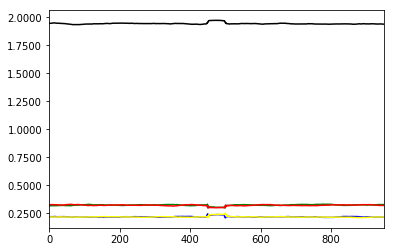

In [92]:
plt.plot(np.arange(0,950), mean_entropy_windows,color='black')
plt.plot(np.arange(0,950), mean_a_freq, color='green')
plt.plot(np.arange(0,950), mean_c_freq, color='blue')
plt.plot(np.arange(0,950), mean_g_freq, color='yellow')
plt.plot(np.arange(0,950), mean_t_freq, color='red')

plt.xlim(0,950)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
plt.show()

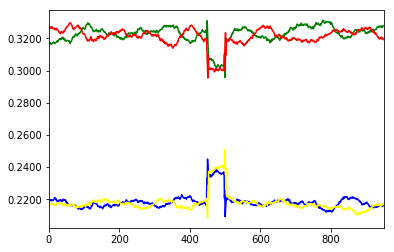

In [93]:
plt.plot(np.arange(0,950), mean_a_freq, color='green')
plt.plot(np.arange(0,950), mean_c_freq, color='blue')
plt.plot(np.arange(0,950), mean_g_freq, color='yellow')
plt.plot(np.arange(0,950), mean_t_freq, color='red')

plt.xlim(0,950)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
plt.show()

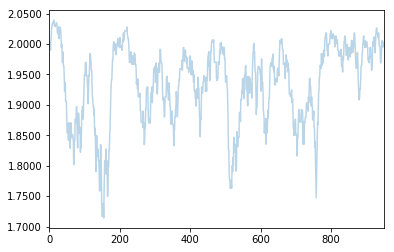

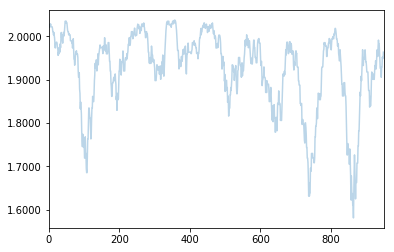

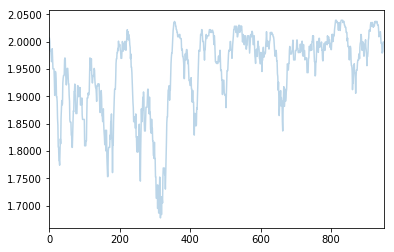

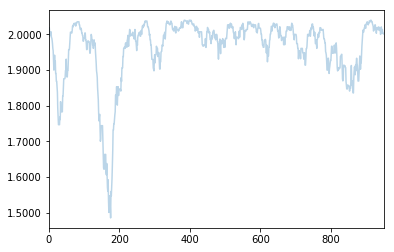

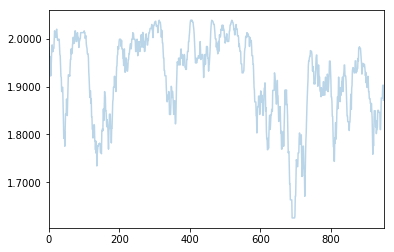

In [78]:
#475-525 is the window around the motif

for entry in entropy_windows[:5]:
  half = int(len(entry)/2)
  half_window = int(window_size/2)
  start = half-half_window
  end = half+half_window
  
  window_around_motif = entry[start:end]
  
  #plt.figure(figsize=(20,2))
      
  plt.plot(np.arange(0,950), entry, alpha=0.3)    
  plt.xlim(0,950)
  plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
  plt.show()

In [58]:
motif_seqs[0][497:503]

'CACGTG'

In [31]:
entropies

[1.934844600673761,
 1.9337157788966994,
 1.9743723301838785,
 1.9828643302299995,
 1.9567705872830503,
 1.9595599597605262,
 1.9993258296879084,
 1.995436374957668,
 1.9354883653813326,
 1.966258763006473,
 1.9456087440839296,
 1.934662836285328,
 1.9901628108924734,
 1.9897763224601916,
 1.957492264395195,
 1.9319974402532925,
 1.9581374522827248,
 1.9852451711719565,
 1.9215397103422487,
 1.9681727706176826,
 1.9148552486379398,
 1.9654973755381935,
 1.981992313338987,
 1.9436845758232795,
 1.9794833286136653,
 1.954075603941813,
 1.959148036495264,
 1.9662054782724003,
 1.939920297038697,
 1.9632972556432584,
 1.967312241657275,
 1.9476801823016867,
 1.9443159479081047,
 1.979219434340994,
 1.9361194156774335,
 1.9511657737161574,
 1.9922559423084187,
 1.9063702479506075,
 1.9648039214158215,
 1.9454648943840636,
 1.977803026253798,
 1.9492965614752047,
 1.9865590800722872,
 1.930701432594628,
 1.93533822406056,
 1.9473386714012495,
 1.9711527658460675,
 1.9603013639398617,
 1.9587

In [27]:
c_num = pho4_motifs[0][0]
c_start = pho4_motifs[0][1]
c_end = pho4_motifs[0][2]
len(genome_object[c_num][c_start:c_end].seq)

1000

In [0]:
![[ -f 1000_around_pho4_onehot.npy ]] || wget http://mitra.stanford.edu/kundaje/eileenli/1000_around_pho4_onehot.npy -O 1000_around_pho4_onehot.npy

In [0]:
import numpy as np
pho4_onehot = np.load("1000_around_pho4_onehot.npy")

In [0]:
np.array(pho4_onehot[0]).shape 

(546, 4)